In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import parc
import scipy.cluster.hierarchy as sch
import matplotlib
from collections import defaultdict
import logging
import pickle
import matplotlib.patches as mpatches
from collections import Counter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path for config
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

# Import path for src
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *
import my_io as io

In [5]:
# Cmap
my_cmap_name = 'viridis'
scale_name = 'Relative Intensity'

#     my_cmap_name = 'bwr'
#     scale_name = 'Z-score'

# Import metadata information

In [6]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

Pos Grades Stage                                         Directory
0  B1      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1  B3      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2  B5      2    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3  C6     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4  D7      3  IIIA  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7

In [7]:
df_metadata

Pos Grades Stage                                         Directory
0   B1      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1   B3      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2   B5      2    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3   C6     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4   D7      3  IIIA  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7
5   D9      3     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI009_D9
6   E1      2    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI012_E1
7   B6     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI015_B6
8   F3      3    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI016_F3
9   F2     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI017_F2
10  G1      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI018_G1
11  G5      1  IIIA  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI019_G5
12  E5      2  IIIB  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI020_E5
13  E7      3    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI021_E7

In [8]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [9]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


# Load clustering result

In [11]:
with open(data_dir / f'clustering_all_down.pickle', 'rb') as f:
    parc_labels, embeddings, df = pickle.load(f)
    

In [12]:
n = 10
embeddings_subset = embeddings[::n, :]
df_subset = df.iloc[::n,:-3]

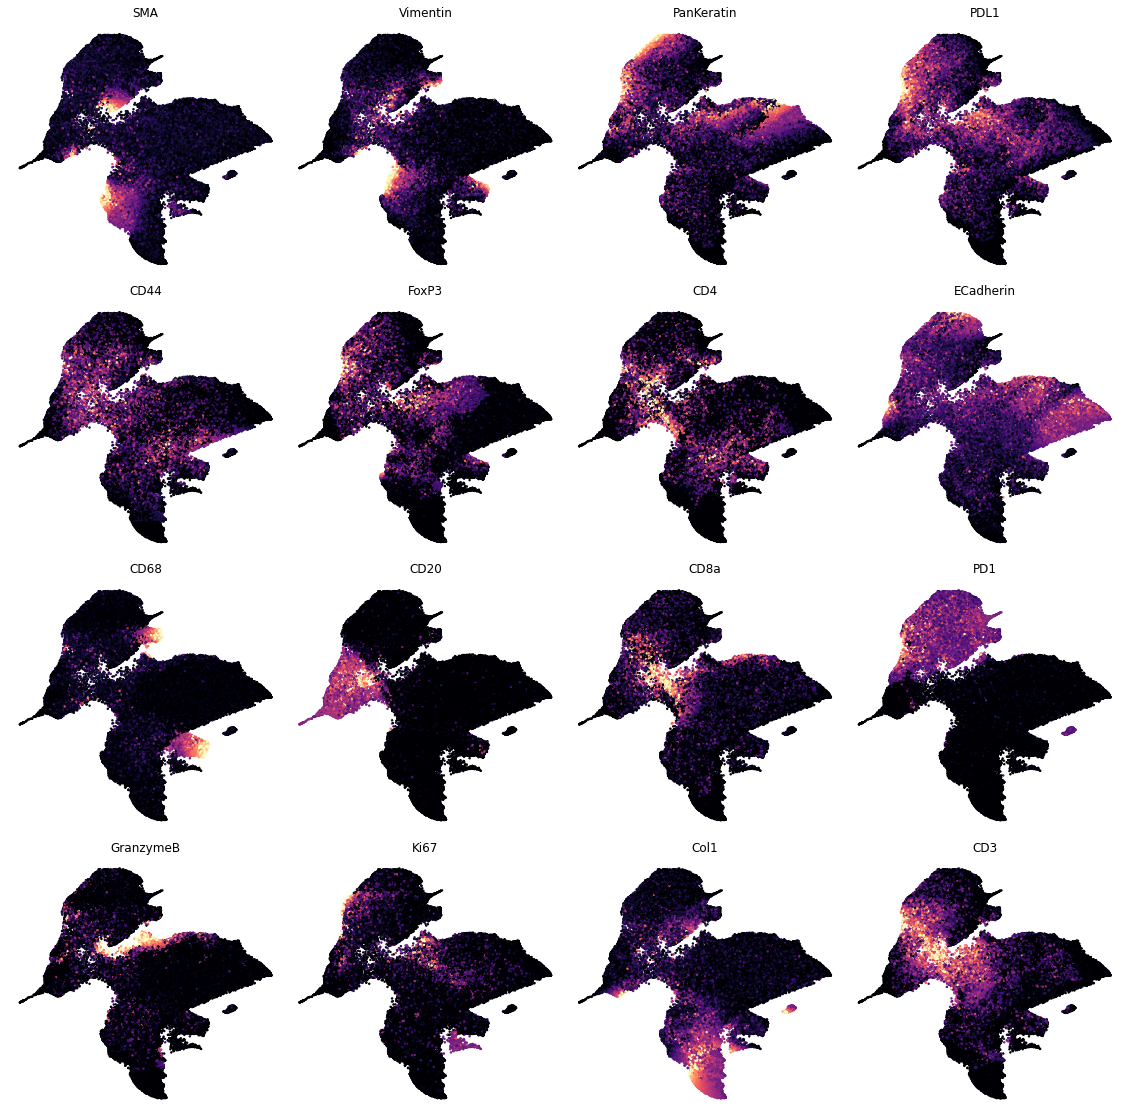

In [13]:
X, Y = embeddings_subset[:, 0], embeddings_subset[:, 1]
markers = df.columns.tolist()
fig, axs = plt.subplots(4,4,figsize=(20, 20))
axs = axs.flatten()
for i, ax in enumerate(axs):
    try:
        ax.scatter(X, Y, c=df_subset.iloc[:,i], s=2, cmap='magma')
        ax.set_title(markers[i])
    except:
        pass
    ax.axis('off')
fig.subplots_adjust(wspace=0.01, hspace=0.1)
    


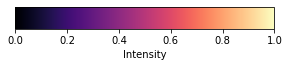

In [14]:
import matplotlib as mpl

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Intensity')

# Viz

Show each cluster marker mean expression level 

In [15]:
def create_HM(
    df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        col_cluster=False,
        row_colors=[row_colors],
        dendrogram_ratio=(0.1, 0.0),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Cluster")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))
    
    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)


def create_umap(embeddings, labels, cmap, name = 'Umap'):
    fig, ax = plt.subplots(figsize=(10, 10))
    X, Y = embeddings[:, 0], embeddings[:, 1]
    ax.scatter(X, Y, c=labels, s=2, cmap=matplotlib.colors.ListedColormap(cmap))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Add arrow with spine
    pos = ax.get_position()
    ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
    ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

    # Add label
    ax.set_xlabel(f'{name} 1')
    ax.set_ylabel(f'{name} 2')

In [16]:
df['label'] = parc_labels

# Get dataframe per cluster
df_per_label = df.groupby("label").mean().iloc[:,:-2]
df_per_label.head()

SMA  Vimentin  PanKeratin      PDL1      CD44     FoxP3       CD4  \
label                                                                           
0      0.074229  0.077078    0.260330  0.370430  0.153872  0.283574  0.104860   
1      0.092917  0.154655    0.109057  0.235272  0.252895  0.131110  0.113786   
2      0.058731  0.059882    0.219491  0.227273  0.186505  0.038641  0.103749   
3      0.057487  0.051458    0.215891  0.201421  0.194154  0.238131  0.038127   
4      0.048934  0.243423    0.090215  0.191629  0.225531  0.118343  0.231007   

       ECadherin      CD68      CD20      CD8a       PD1  GranzymeB      Ki67  \
label                                                                           
0       0.307189  0.067678  0.016857  0.072694  0.375302   0.076530  0.138351   
1       0.216144  0.072532  0.083028  0.396720  0.143715   0.096568  0.059548   
2       0.362282  0.066885  0.012220  0.058900  0.312660   0.067658  0.043274   
3       0.395843  0.061986  0.009111  0.045619  0.011925   0.069538  0.039677   
4       0.203985  0.523618  0.033260  0.069445  0.014920   0.029877  0.029773   

           Col1       CD3    CD45RO  
label                                
0      0.081143  0.212950  0.270564  
1      0.135723  0.416494  0.384242  
2      0.072100  0.110353  0.178673  
3      0.072895  0.100544  0.151795  
4      0.085547  0.107206  0.192984

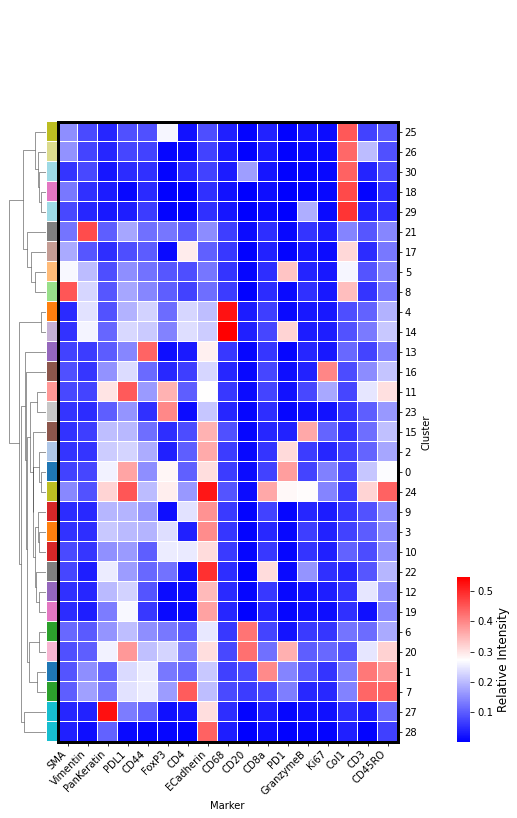

In [17]:
my_cmap = "bwr"
scale_name = "Relative Intensity"

# Get linkage
d = sch.distance.pdist(df_per_label, metric='cosine')
L = sch.linkage(d, method="average")

# Get colormap
vals = np.linspace(0, 1, len(df_per_label))
my_cmap_row = plt.cm.tab20(vals)

# Clustermap and umap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)

create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

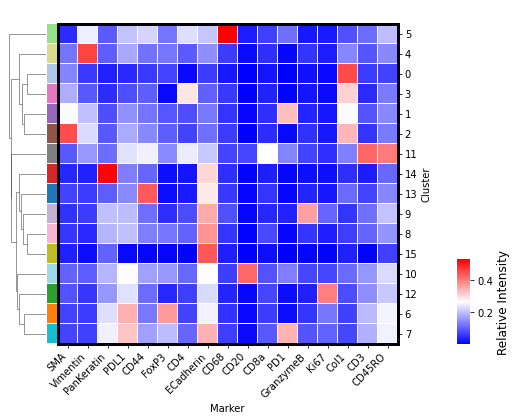

In [18]:
tol = 0.20

# Merge similar cluster
clusters = sch.fcluster(L, tol * d.max(), "distance")-1
clusters_unique = np.unique(clusters)
n_clusters = len(np.unique(clusters))

# Clustermap and umap
label2cluster = dict(zip(labels, clusters))
result = defaultdict(int)
for k, v in zip(clusters, labels):
    result[k] = max(result[k], v)
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(result).map(my_cmap_dict)
clusters = np.array(list(map(label2cluster.get, parc_labels)))
new_parc_labels = np.array(list(map(result.get, clusters)))

# Clustermap and umap with new colormap
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
# vals = np.array([0.2, 0.5, 0.7, 0.3, 0.6, 0.4, 0.9, 0.0])
my_cmap_row = plt.cm.tab20(vals)
my_cmap_dict = dict(zip(clusters_unique, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(my_cmap_dict)
new_parc_labels = np.array(list(map(label2cluster.get, parc_labels)))

# Combined 
df_combined = df.copy()
df_combined.label = df_combined.label.map(label2cluster.get)
df_combined = df_combined.groupby("label").mean().iloc[:,:-2]
labels = df_combined.index.to_list()

row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)

create_HM(df_combined, my_cmap, row_colors, scale_name, cellSizePixels=20)

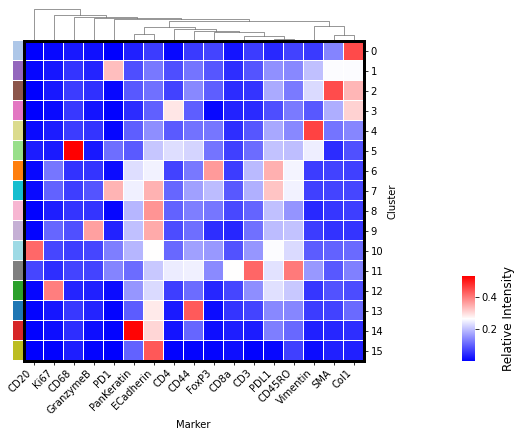

In [19]:
def create_HM_col(df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
    Ny,Nx = df_per_label.shape
    figWidth = (Nx*cellSizePixels/dpi)/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/marginHeight
    
    ax = sns.clustermap(df_per_label,
                        cmap=my_cmap,
                        linewidth=0.5,
                        row_cluster=False,
                        row_colors=[row_colors],
                        dendrogram_ratio=(0.0, 0.1),
                        figsize=(figWidth, figHeigh),
                        **kwargs
                        )
    ax.ax_heatmap.set_yticklabels(
        ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.ax_heatmap.set_xlabel('Marker')
    ax.ax_heatmap.set_ylabel('Cluster')
    
    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  axWidth, axHeight])

    # resize dendrograms to match
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                         ax_row_orig_pos.width, axHeight])

    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))
    
    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

d2 = sch.distance.pdist(df_combined.T, metric='cosine')
L2 = sch.linkage(d2, method="average")
create_HM_col(df_combined, my_cmap, row_colors, scale_name, col_linkage=L2, cellSizePixels=20)

In [20]:
n = 1
embeddings_subset = embeddings[::n, :]
parc_labels_subset = parc_labels[::n]

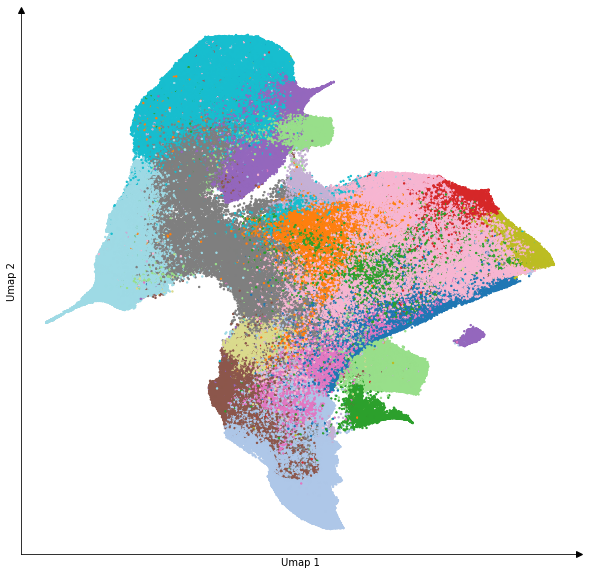

In [21]:
create_umap(embeddings_subset, list(map(label2cluster.get, parc_labels_subset)), my_cmap_row)

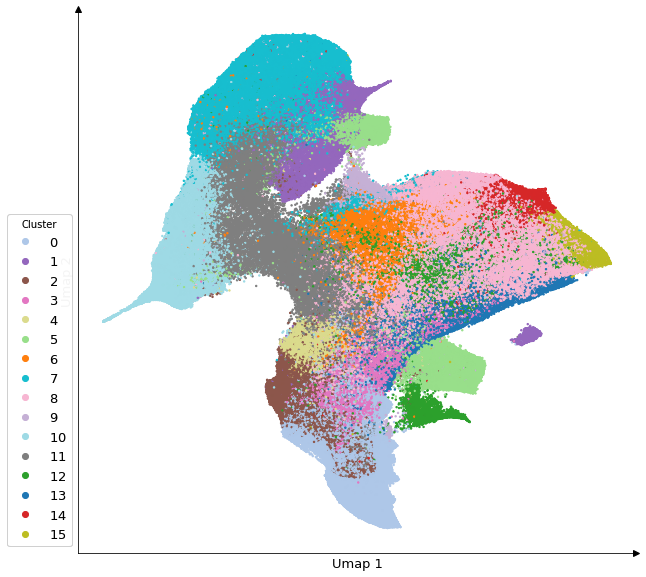

In [22]:
name='Umap'
fig, ax = plt.subplots(figsize=(10, 10))
X, Y = embeddings[:, 0], embeddings[:, 1]
scatter = ax.scatter(X, Y, c=list(map(label2cluster.get, parc_labels_subset)), s=2, cmap=matplotlib.colors.ListedColormap(my_cmap_row))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add arrow with spine
pos = ax.get_position()
ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Add label
ft = 13
ax.set_xlabel(f'{name} 1', fontsize=ft)
ax.set_ylabel(f'{name} 2', fontsize=ft)

legend1 = ax.legend(handles=scatter.legend_elements(num=15)[0], 
                    labels=scatter.legend_elements(num=15)[1],
                    bbox_to_anchor=(0, 0),
                    loc="lower right", 
                    title="Cluster",
                    fontsize=13)
ax.add_artist(legend1)

Look at each ROI pixel clustered version

In [65]:
def create_clustered_pixel(x, y, labels, path, my_cmap, **kwargs):
    x_max = np.max(x)
    y_max = np.max(y)
    img_labeled = np.zeros((x_max+1, y_max+1)) * np.NaN
    img_labeled[x, y] = labels
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_labeled, interpolation='None', cmap=plt.cm.colors.ListedColormap(my_cmap), **kwargs)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
                   left=False, labelleft=False)
    
#     count = Counter(labels)
#     count_sorted = dict(count.most_common())
#     # Color legend
#     patches = [
#         mpatches.Patch(color=my_cmap[i], label=i)
#         for i in count_sorted.keys()
#         if count[i] > 200
#     ]
#     ax.legend(
#         handles=patches,
#         bbox_to_anchor=(0, 0),
#         loc="lower right",
#         borderaxespad=0.0,
#         fontsize=8,
#     )
    ax.patch.set_facecolor("k")
    fig.savefig(path, bbox_inches='tight')

In [66]:
ROIs = df.ROI.unique()
ROI = ROIs[0]

Counter({9: 51961, 6: 46166, 8: 15730, 7: 14871, 0: 4549, 1: 3956, 3: 3349, 4: 2873, 5: 1728, 10: 1082, 2: 645})


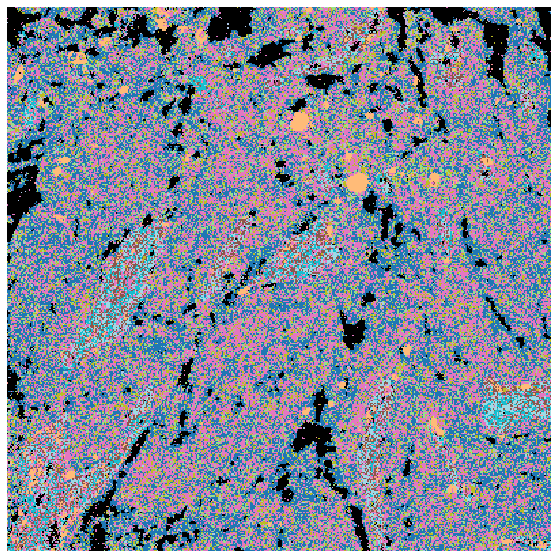

Counter({9: 27667, 0: 22882, 1: 17823, 7: 15763, 8: 14819, 4: 11437, 3: 8077, 6: 7638, 5: 4070, 2: 1510, 10: 1360, 11: 2})


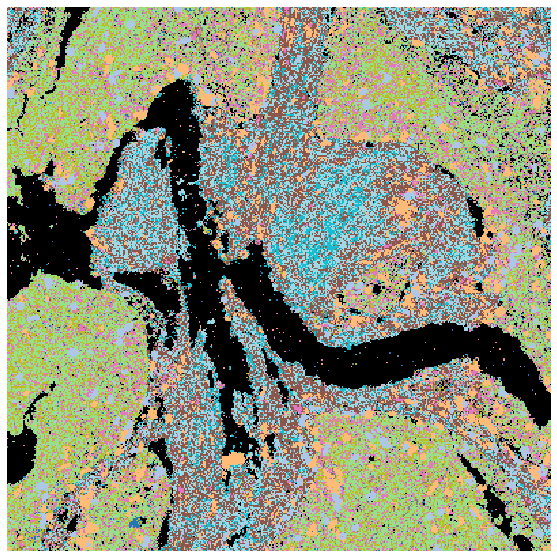

Counter({7: 38946, 9: 29163, 8: 27824, 0: 7978, 5: 6528, 6: 5563, 4: 4667, 1: 3925, 3: 3476, 10: 2813, 2: 909})


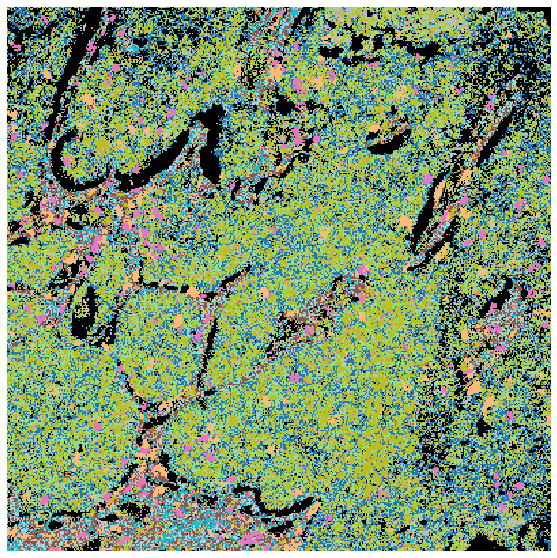

Counter({4: 25827, 7: 24419, 8: 24159, 6: 12163, 9: 10378, 0: 9270, 5: 5334, 3: 3755, 1: 3238, 2: 1196, 10: 981, 11: 7})


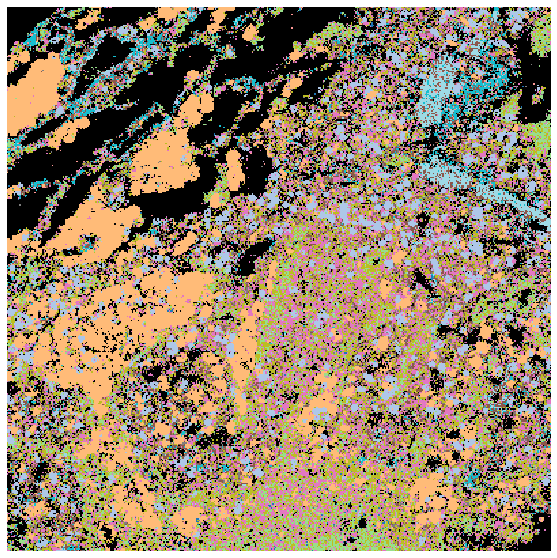

Counter({4: 32974, 9: 28821, 8: 24704, 7: 16915, 0: 12758, 6: 10981, 1: 6657, 3: 5021, 5: 3835, 2: 1484, 10: 731})


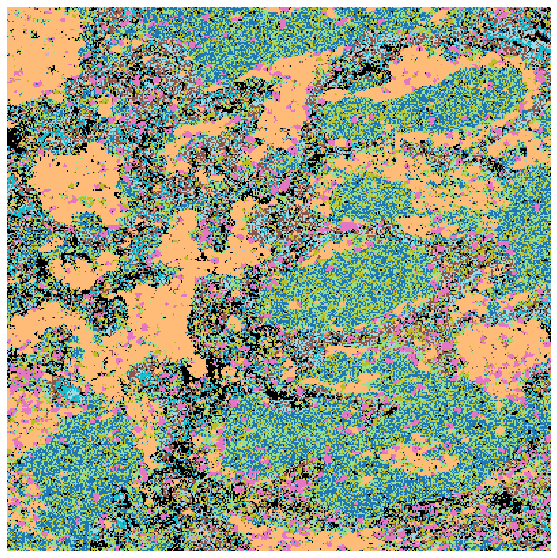

Counter({9: 25192, 7: 22908, 3: 21489, 8: 18630, 1: 15599, 0: 10204, 4: 5383, 2: 4584, 6: 4449, 5: 2782, 10: 1583})


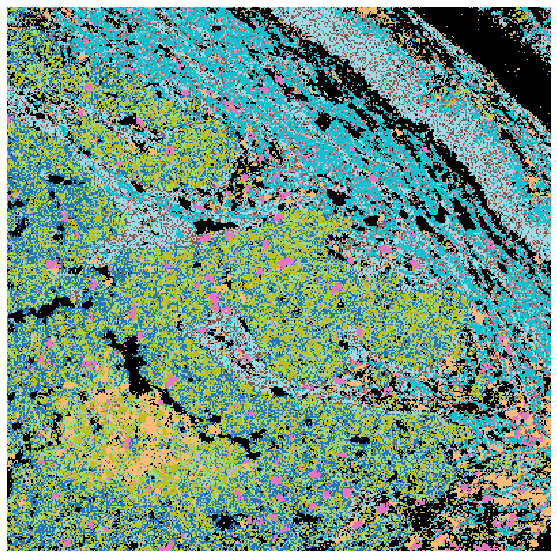

Counter({6: 29508, 7: 21156, 0: 19423, 8: 16951, 9: 13302, 4: 11408, 1: 5712, 5: 5382, 3: 3978, 2: 1358, 10: 577, 11: 1})


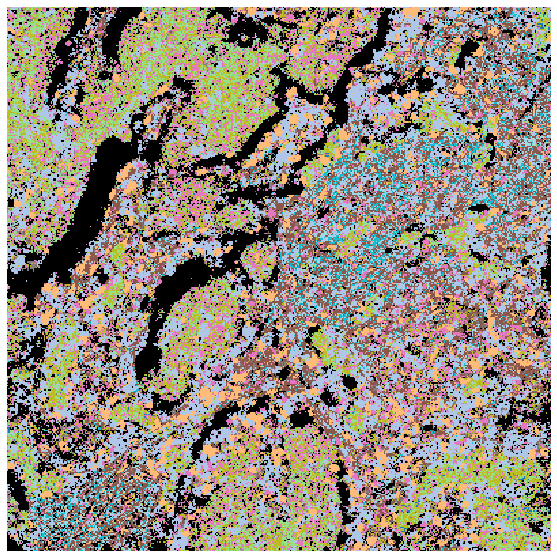

Counter({3: 15749, 7: 11545, 1: 7770, 0: 7193, 8: 6507, 9: 5167, 4: 5115, 2: 3705, 6: 3647, 5: 2560, 10: 1028, 11: 18})


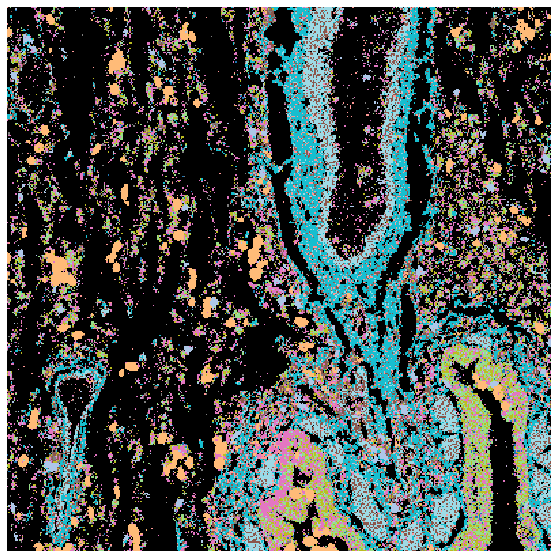

Counter({6: 34165, 9: 32347, 7: 25374, 4: 15117, 8: 6557, 1: 6228, 3: 5827, 0: 4323, 2: 3637, 10: 1504, 5: 1436, 11: 2})


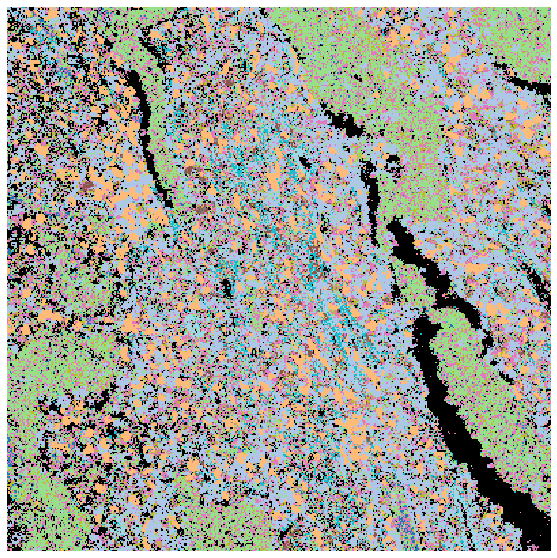

Counter({4: 28091, 7: 22942, 8: 14969, 9: 12210, 6: 8950, 3: 8674, 0: 6049, 5: 5613, 1: 2843, 10: 2788, 2: 2325, 11: 5})


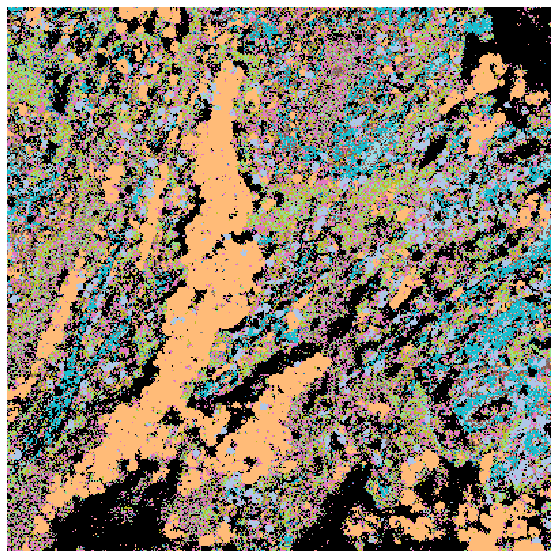

Counter({1: 22116, 3: 21325, 0: 16087, 9: 12553, 7: 10404, 2: 8579, 5: 6419, 4: 5760, 6: 4769, 10: 3861, 8: 3392, 11: 333})


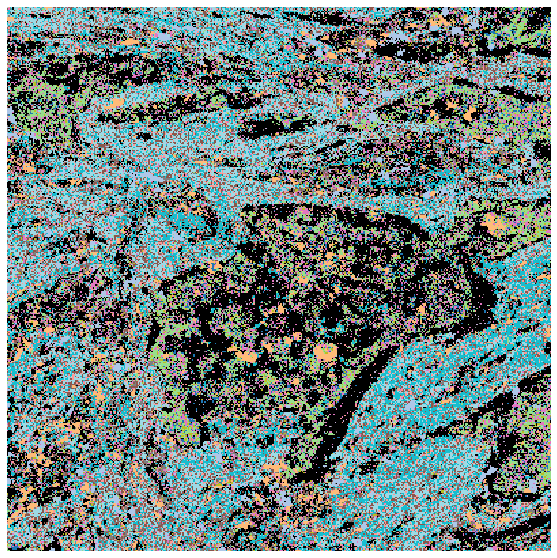

Counter({9: 26862, 8: 25249, 7: 22283, 0: 10290, 10: 5536, 1: 5471, 5: 4451, 6: 4381, 3: 4178, 4: 3231, 2: 1148, 11: 12})


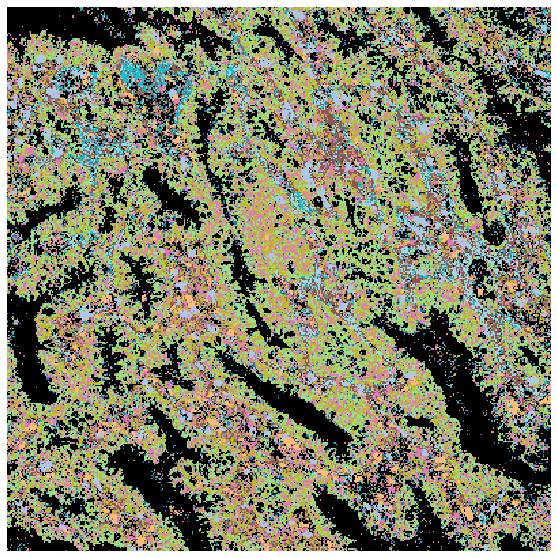

Counter({9: 24445, 6: 19556, 3: 17066, 7: 15236, 8: 6310, 5: 5117, 1: 4053, 2: 2996, 4: 2951, 0: 2882, 10: 2666, 11: 3})


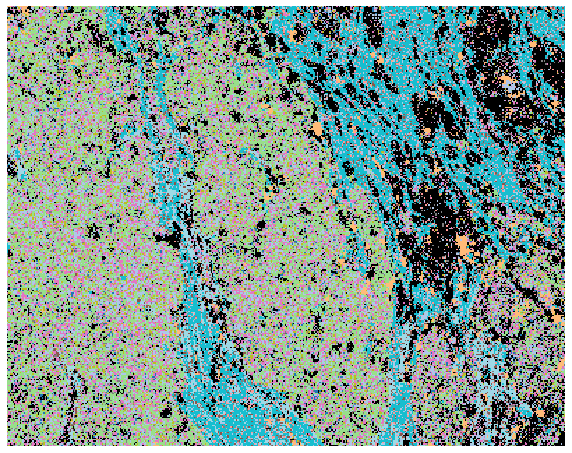

Counter({9: 49663, 7: 31620, 10: 10831, 8: 10453, 6: 10379, 5: 6231, 1: 2759, 0: 2447, 3: 1601, 4: 1454, 2: 848, 11: 17})


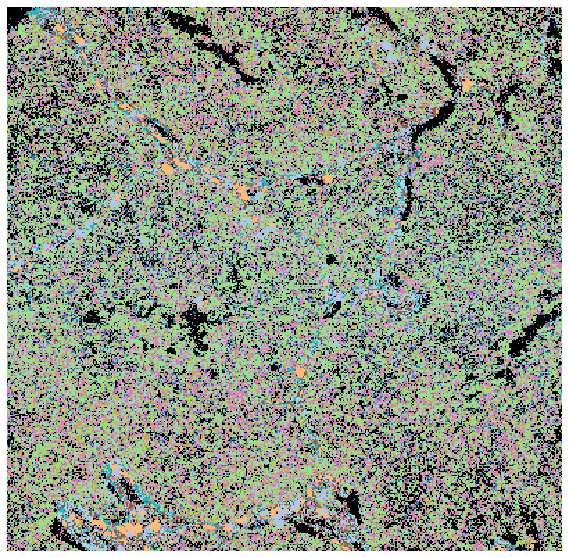

In [67]:
for ROI in ROIs:
    df_subset = df[df.ROI == ROI]
    x = df_subset.X.tolist()
    y = df_subset.Y.tolist()
    labels = np.array(list(map(label2cluster.get, df_subset.label)))
    print(Counter(labels))
    create_clustered_pixel(x, y, labels, data_figure / 'pixel_cluster' / f'{ROI}.png', my_cmap_row)
    plt.show()

## Viz ROI count per cluster

In [68]:
def create_HM_count(
    df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        row_cluster=False,
        row_colors=[row_colors],
         dendrogram_ratio=(0.0, 0.1),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Cluster")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.1, pos.y0, .03, cbar_size))

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)


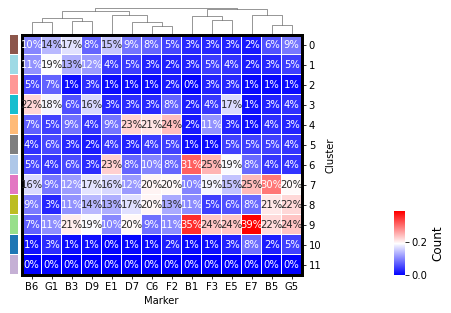

In [69]:
from matplotlib.colors import LogNorm

df_count = df.copy()
df_count.label = df_count.label.map(label2cluster.get)
df_count = df_count.groupby(['ROI', 'label']).size().reset_index(name='counts')
df_count = df_count.pivot(index='ROI', columns='label', values='counts')
df_count.fillna(0, inplace=True)

df_count = df_count.div(df_count.sum(axis=1), axis=0)
df_count.index = [index[-2:] for index in df_count.index]

create_HM_count(df_count.T, "bwr", row_colors, 'Count', cellSizePixels=20, annot=True, fmt=".0%")

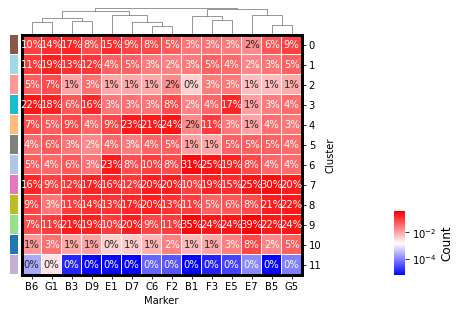

In [70]:

df_count = df.copy()
df_count.label = df_count.label.map(label2cluster.get)
df_count = df_count.groupby(['ROI', 'label']).size().reset_index(name='counts')
df_count = df_count.pivot(index='ROI', columns='label', values='counts')
df_count.fillna(1, inplace=True)

df_count = df_count.div(df_count.sum(axis=1), axis=0)
df_count.index = [index[-2:] for index in df_count.index]

create_HM_count(df_count.T, "bwr", row_colors, 'Count', cellSizePixels=20, annot=True, fmt=".0%", norm=LogNorm())